### Importing libraries

In [51]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np


### Load Dataset

In [52]:
ds = load_dataset("benstaf/FNSPID-filtered-nasdaq-100")
df = ds["train"].to_pandas()
df['Date'] = pd.to_datetime(df['Date'])
df.info()

Using custom data configuration benstaf--FNSPID-filtered-nasdaq-100-cb77f2f406eb844d
Reusing dataset parquet (/Users/wins/.cache/huggingface/datasets/benstaf___parquet/benstaf--FNSPID-filtered-nasdaq-100-cb77f2f406eb844d/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)
100%|██████████| 1/1 [00:00<00:00, 21.75it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358154 entries, 0 to 358153
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   Unnamed: 0        358154 non-null  object             
 1   Date              358154 non-null  datetime64[ns, UTC]
 2   Article_title     358154 non-null  object             
 3   Stock_symbol      358154 non-null  object             
 4   Url               358154 non-null  object             
 5   Publisher         358154 non-null  object             
 6   Author            358154 non-null  object             
 7   Article           358154 non-null  object             
 8   Lsa_summary       358154 non-null  object             
 9   Luhn_summary      358154 non-null  object             
 10  Textrank_summary  358154 non-null  object             
 11  Lexrank_summary   358154 non-null  object             
dtypes: datetime64[ns, UTC](1), object(11)
memory

/var/folders/w4/5fjrknc54qjdkx2hts27gd6m0000gn/T/ipykernel_20047/3579838760.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date_only'] = df_filtered['Date'].dt.date


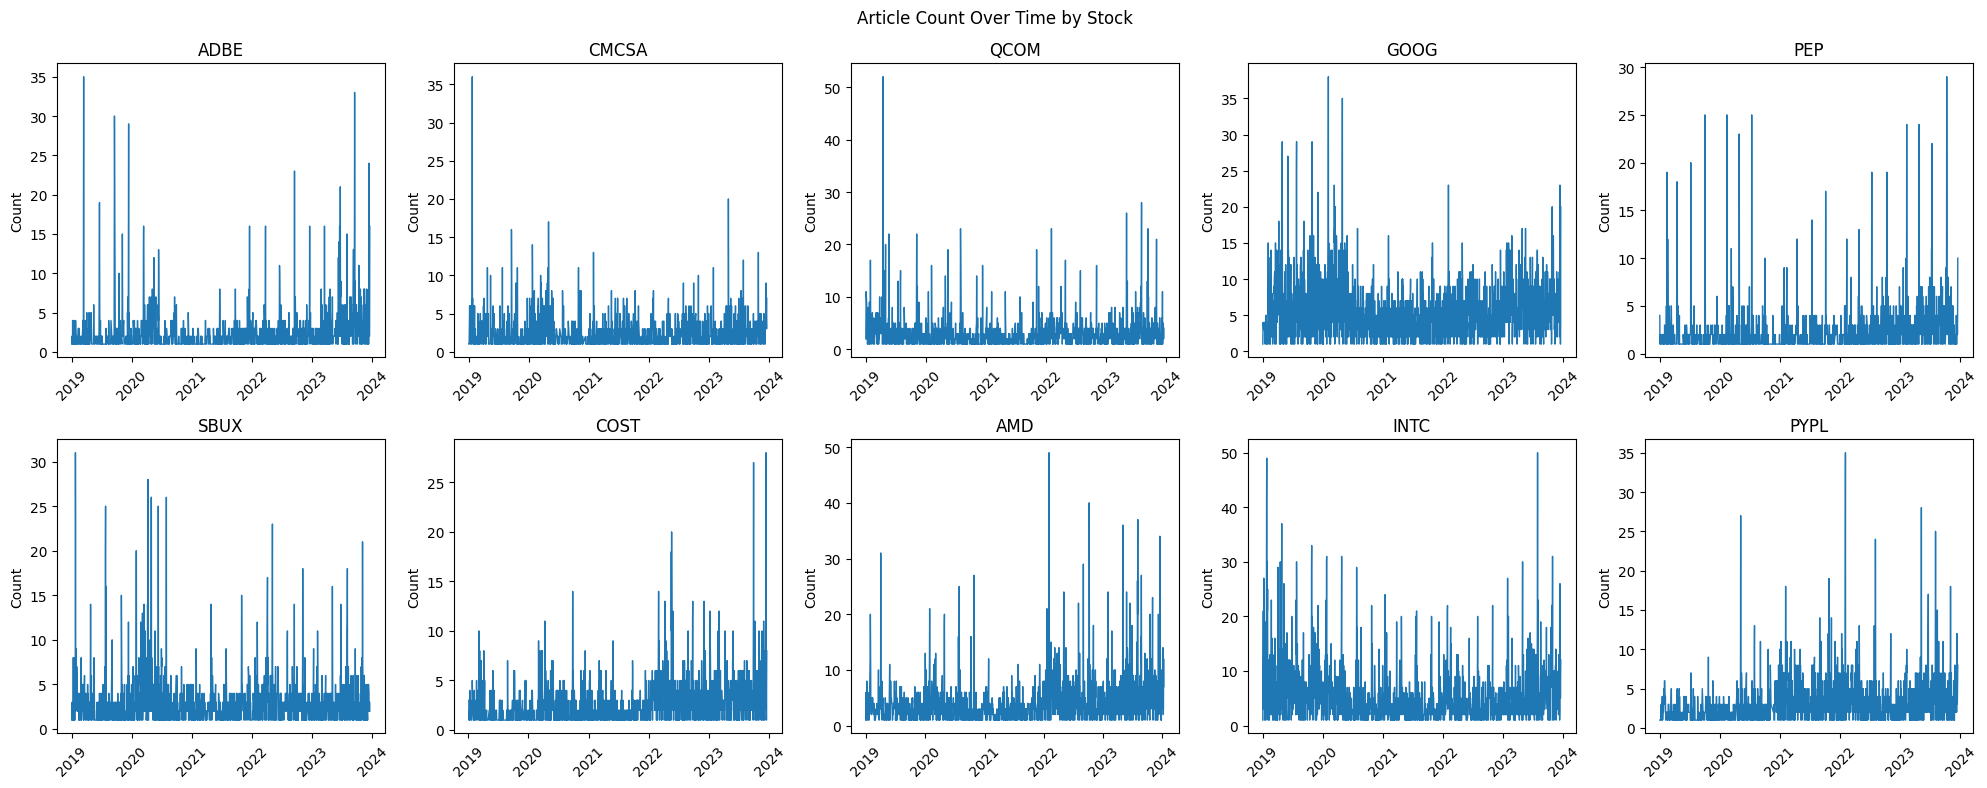

Latest date in filtered dataset: 2024-01-09 00:00:00+00:00


In [135]:
# Define date range and top stocks
date_start = '2019-01-01'
date_end = '2024-12-31'
top_stocks_list = [
    "ADBE", "CMCSA", "QCOM", "GOOG", "PEP",
    "SBUX", "COST", "AMD", "INTC", "PYPL"
]

# Filter and process dataframe
df_filtered = df[
    (df['Date'] >= date_start) & 
    (df['Date'] <= date_end) &
    (df['Stock_symbol'].isin(top_stocks_list))
]

# Add date-only column for plotting
df_filtered['Date_only'] = df_filtered['Date'].dt.date

# Create subplots for each stock
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Article Count Over Time by Stock')

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

# Plot each stock
for idx, stock in enumerate(top_stocks_list):
    stock_data = df_filtered[df_filtered['Stock_symbol'] == stock]
    
    # Count articles per day
    daily_counts = stock_data.groupby('Date_only').size()
    
    # Plot
    axes_flat[idx].plot(daily_counts.index, daily_counts.values, linewidth=1)
    axes_flat[idx].set_title(stock)
    axes_flat[idx].tick_params(axis='x', rotation=45)
    axes_flat[idx].set_xlabel('')
    axes_flat[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Find and print latest date in filtered dataset
latest_date = df_filtered['Date'].max()
print(f"Latest date in filtered dataset: {latest_date}")


In [67]:
# Check for empty values that aren't NA
empty_check = df_filtered[
    (df_filtered['Article'].str.strip() == '') | 
    (df_filtered['Lsa_summary'].str.strip() == '') |
    (df_filtered['Luhn_summary'].str.strip() == '') |
    (df_filtered['Textrank_summary'].str.strip() == '') |
    (df_filtered['Lexrank_summary'].str.strip() == '')
]

print("Number of rows with empty strings:", len(empty_check))
if len(empty_check) > 0:
    print("\nSample of rows with empty strings:")
    print(empty_check.head())
    
    print("\nDetailed empty string counts per column:")
    empty_counts = {
        'Article': len(df_filtered[df_filtered['Article'].str.strip() == '']),
        'LSA Summary': len(df_filtered[df_filtered['Lsa_summary'].str.strip() == '']),
        'Luhn Summary': len(df_filtered[df_filtered['Luhn_summary'].str.strip() == '']), 
        'TextRank Summary': len(df_filtered[df_filtered['Textrank_summary'].str.strip() == '']),
        'LexRank Summary': len(df_filtered[df_filtered['Lexrank_summary'].str.strip() == ''])
    }
    for col, count in empty_counts.items():
        print(f"{col}: {count} empty strings")


Number of rows with empty strings: 5792

Sample of rows with empty strings:
       Unnamed: 0                      Date  \
225628            2020-06-08 06:57:41+00:00   
225629            2020-06-04 06:48:11+00:00   
225630            2020-05-27 06:24:38+00:00   
225631            2020-05-26 06:32:14+00:00   
225632            2020-05-20 06:19:31+00:00   

                                            Article_title Stock_symbol  \
225628  UBS Maintains Buy on Adobe, Raises Price Targe...         ADBE   
225629          Stocks That Hit 52-Week Highs On Thursday         ADBE   
225630  Shares of several companies in the broader tec...         ADBE   
225631           Stocks That Hit 52-Week Highs On Tuesday         ADBE   
225632  Shares of several technology companies are tra...         ADBE   

                                                      Url          Publisher  \
225628  https://www.benzinga.com/news/20/06/16202690/u...  Benzinga Newsdesk   
225629  https://www.benzinga.com/new

In [68]:
df_clean = df_filtered[
    (df_filtered['Article'].str.strip() != '') & 
    (df_filtered['Lsa_summary'].str.strip() != '') &
    (df_filtered['Luhn_summary'].str.strip() != '') &
    (df_filtered['Textrank_summary'].str.strip() != '') &
    (df_filtered['Lexrank_summary'].str.strip() != '')
].copy()

print(f"Original dataset size: {len(df_filtered)}")
print(f"Clean dataset size: {len(df_clean)}")
print(f"Removed {len(df_filtered) - len(df_clean)} rows with empty strings")


Original dataset size: 52531
Clean dataset size: 46739
Removed 5792 rows with empty strings


/var/folders/w4/5fjrknc54qjdkx2hts27gd6m0000gn/T/ipykernel_20047/1147428668.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(length_data.values(), labels=length_data.keys())


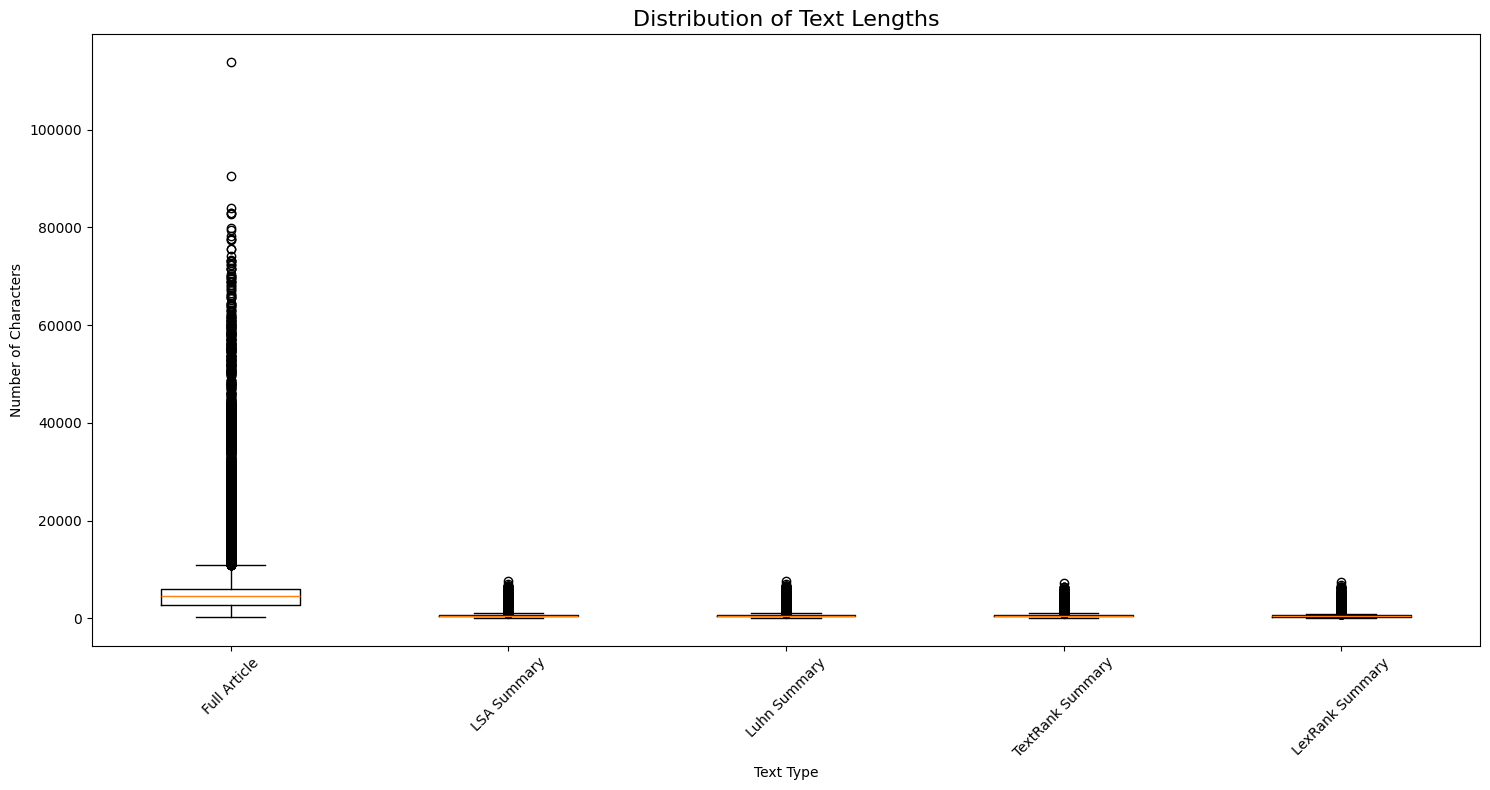


Text Length Statistics and Outliers:
--------------------------------------------------

Full Article:
Mean length: 5395 characters
Median length: 4549 characters
Min length: 294 characters
Max length: 113847 characters
Number of outliers: 2039
Sample of outliers (first 5):
[43194 12350 11341 27419 12487]

LSA Summary:
Mean length: 548 characters
Median length: 522 characters
Min length: 108 characters
Max length: 7641 characters
Number of outliers: 804
Sample of outliers (first 5):
[1116  998 1075 1122  995]

Luhn Summary:
Mean length: 544 characters
Median length: 498 characters
Min length: 110 characters
Max length: 7641 characters
Number of outliers: 1068
Sample of outliers (first 5):
[1116 1161 1075 1715 1189]

TextRank Summary:
Mean length: 582 characters
Median length: 538 characters
Min length: 116 characters
Max length: 7151 characters
Number of outliers: 998
Sample of outliers (first 5):
[1116 1132 1309 1075 1715]

LexRank Summary:
Mean length: 493 characters
Median length: 

In [70]:
# Calculate lengths of articles and summaries
length_data = {
    'Full Article': df_clean['Article'].str.len(),
    'LSA Summary': df_clean['Lsa_summary'].str.len(),
    'Luhn Summary': df_clean['Luhn_summary'].str.len(), 
    'TextRank Summary': df_clean['Textrank_summary'].str.len(),
    'LexRank Summary': df_clean['Lexrank_summary'].str.len()
}

# Create figure for boxplot
plt.figure(figsize=(15, 8))
plt.boxplot(length_data.values(), labels=length_data.keys())
plt.title('Distribution of Text Lengths', fontsize=16)
plt.xlabel('Text Type')
plt.ylabel('Number of Characters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics and outliers
print("\nText Length Statistics and Outliers:")
print("-" * 50)

for name, lengths in length_data.items():
    # Calculate statistics
    q1 = lengths.quantile(0.25)
    q3 = lengths.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    # Find outliers
    outliers = lengths[(lengths < lower_bound) | (lengths > upper_bound)]
    
    print(f"\n{name}:")
    print(f"Mean length: {lengths.mean():.0f} characters")
    print(f"Median length: {lengths.median():.0f} characters")
    print(f"Min length: {lengths.min():.0f} characters")
    print(f"Max length: {lengths.max():.0f} characters")
    print(f"Number of outliers: {len(outliers)}")
    if len(outliers) > 0:
        print("Sample of outliers (first 5):")
        print(outliers.head().values)


In [79]:
# Check for duplicate URLs and compare articles with highest duplicate counts
print("\nChecking for duplicate URLs and comparing articles:")
print("-" * 50)

if 'Url' in df_clean.columns:
    # Get entries with duplicate URLs
    url_duplicates = df_clean[df_clean.duplicated(subset=['Url'], keep=False)]
    print(f"\nDuplicate URLs found: {len(url_duplicates)}")
    
    if len(url_duplicates) > 0:
        # Count duplicates per URL and sort by count
        url_counts = url_duplicates['Url'].value_counts()
        print("\nTop URLs by duplicate count:")
        
        # Get top 3 URLs with most duplicates
        for url in url_counts.head(3).index:
            entries = url_duplicates[url_duplicates['Url'] == url]
            print(f"\nURL: {url}")
            print(f"Number of duplicates: {len(entries)}")
            print("\nArticle comparison:")
            for idx, row in entries.iterrows():
                print(f"\nDate: {row['Date']}")
                print(f"Title: {row['Article_title']}")
                print(f"First 200 chars of article: {row['Article'][:200]}...")
            print("-" * 80)
        if len(url_counts) > 3:
            print(f"\n... and {len(url_counts) - 3} more URLs with duplicates")
else:
    print("\nNote: URL column not found in dataset")



Checking for duplicate URLs and comparing articles:
--------------------------------------------------

Duplicate URLs found: 8482

Top URLs by duplicate count:

URL: https://www.nasdaq.com/articles/the-top-10-constituents-of-the-nasdaq-100-index
Number of duplicates: 6

Article comparison:

Date: 2022-08-26 00:00:00+00:00
Title: The Top 10 Constituents of the Nasdaq-100 Index
First 200 chars of article: L
aunched in 1985, the Nasdaq-100 (NDX) is a modified capitalization weighted index that tracks the largest non-financial companies listed on the Nasdaq Stock Exchange. The Nasdaq-100 Index brings tog...

Date: 2022-08-26 00:00:00+00:00
Title: The Top 10 Constituents of the Nasdaq-100 Index
First 200 chars of article: L
aunched in 1985, the Nasdaq-100 (NDX) is a modified capitalization weighted index that tracks the largest non-financial companies listed on the Nasdaq Stock Exchange. The Nasdaq-100 Index brings tog...

Date: 2022-08-26 00:00:00+00:00
Title: The Top 10 Constituents of 

#### Function to load and filter dataset

In [108]:
def load_and_filter_fnspid(selected_symbols=None, start_date=None, end_date=None):
    ds = load_dataset("benstaf/FNSPID-filtered-nasdaq-100")
    df = ds["train"].to_pandas()

    # Convert to datetime and localize timezone to match input
    df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)

    # Filter by date range if provided
    if start_date:
        df = df[df['Date'] >= pd.to_datetime(start_date).tz_localize(None)]
    if end_date:
        df = df[df['Date'] <= pd.to_datetime(end_date).tz_localize(None)]

    # Filter by selected symbols if provided
    if selected_symbols is not None:
        df = df[df['Stock_symbol'].isin(selected_symbols)].copy()
    
    # Remove empty articles
    df = df[df['Article'].str.strip() != '']
    
    # Remove duplicates based on Article content and URL
    df = df.drop_duplicates(subset=['Article', 'Url'])

    return df

#### Function for sentiment analysis

In [81]:
def analyze_finbert_sentiment(df, text_columns=None, model_name="ProsusAI/finbert"):
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

    keep_cols = ['Date', 'Stock_symbol', 'Article_title', 'Article']
    if text_columns is None:
        text_columns = ['Lsa_summary', 'Luhn_summary', 'Textrank_summary', 'Lexrank_summary']
    df = df[keep_cols + text_columns].copy()

    label_to_score = {"positive": 1, "neutral": 0, "negative": -1}
    
    def get_average_sentiment(row):
        sentiments = []
        for col in text_columns:
            text = str(row[col])[:512]  # truncate to safe length
            try:
                result = sentiment_pipeline(text)[0]
                sentiment_label = result['label'].lower()
                confidence = result['score']
                score = label_to_score.get(sentiment_label, 0) * confidence
                sentiments.append(score)
            except Exception:
                sentiments.append(0)  # default to neutral on error
        return sum(sentiments) / len(sentiments) if sentiments else 0
    
    # Apply row-wise
    df['avg_sentiment'] = df.apply(get_average_sentiment, axis=1)
    
    return df

#### Function to aggregate daily sentiment scores

In [110]:
def aggregate_daily_sentiment(df, sentiment_column='avg_sentiment'):
    df = df.copy()
    
    # Ensure 'Date' is datetime if not already
    df['Date'] = pd.to_datetime(df['Date']).dt.date

    def compute_ratios(group):
        total = len(group)
        pos_ratio = (group[sentiment_column] > 0).sum() / total
        neg_ratio = (group[sentiment_column] < 0).sum() / total
        neu_ratio = (group[sentiment_column] == 0).sum() / total
        return pd.Series({
            'positive_ratio': pos_ratio,
            'negative_ratio': neg_ratio,
            'neutral_ratio': neu_ratio
        })

    # Aggregate basic stats
    df_stats = (
        df.groupby(['Stock_symbol', 'Date'])[sentiment_column]
          .agg([
              ('daily_sentiment', 'mean'),
              ('sentiment_std', 'std'),
              ('article_count', 'count'),
              ('sentiment_median', 'median'),
              ('sentiment_min', 'min'),
              ('sentiment_max', 'max')
          ])
          .reset_index()
    )

    # Compute ratio features
    df_ratios = (
        df.groupby(['Stock_symbol', 'Date'])
          .apply(compute_ratios)
          .reset_index()
    )

    # Merge stats + ratios
    df_daily = pd.merge(df_stats, df_ratios, on=['Stock_symbol', 'Date'])

    # Add sentiment range (max - min)
    df_daily['sentiment_range'] = df_daily['sentiment_max'] - df_daily['sentiment_min']

    return df_daily

In [59]:
goog_entry = df_filtered[df_filtered["Stock_symbol"] == "GOOG"].head(1)
goog_entry_tail = df_filtered[df_filtered["Stock_symbol"] == "GOOG"].tail(1)

In [89]:
# Get 5 GOOG examples
goog_examples = df_filtered[df_filtered["Stock_symbol"] == "GOOG"].head(5)

print("Article Summaries:")
print("-" * 80)
for idx, row in goog_examples.iterrows():
    print(f"\nExample {idx}:")
    print(f"Title: {row['Article_title']}")
    print("\nLSA Summary:")
    print(row['Lsa_summary'])
    print("\nLuhn Summary:") 
    print(row['Luhn_summary'])
    print("\nTextRank Summary:")
    print(row['Textrank_summary'])
    print("\nLexRank Summary:")
    print(row['Lexrank_summary'])
    print("-" * 80)

print("\nSentiment Analysis Results:")
print("\n1. Using ProsusAI/finbert:")
print(analyze_finbert_sentiment(goog_examples, model_name="ProsusAI/finbert"))

print("\n2. Using mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis:")
print(analyze_finbert_sentiment(goog_examples, 
    model_name="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"))

print("\nSentiment Analysis Results:")
print("\n1. Using yiyanghkust/finbert-tone:")
print(analyze_finbert_sentiment(goog_examples, model_name="yiyanghkust/finbert-tone"))

Article Summaries:
--------------------------------------------------------------------------------

Example 107508:
Title: Alphabet Inc. (GOOG) Rises As Market Takes a Dip: Key Facts

LSA Summary:
In the latest trading session, Alphabet Inc. (GOOG) closed at $139.66, marking a +1.13% move from the previous day. GOOG's full-year Zacks Consensus Estimates are calling for earnings of $5.75 per share and revenue of $254.8 billion. One should further note that GOOG currently holds a PEG ratio of 1.45.

Luhn Summary:
In the latest trading session, Alphabet Inc. (GOOG) closed at $139.66, marking a +1.13% move from the previous day. Click to get this free report Alphabet Inc. (GOOG) : Free Stock Analysis Report To read this article on Zacks.com click here. GOOG's full-year Zacks Consensus Estimates are calling for earnings of $5.75 per share and revenue of $254.8 billion.

TextRank Summary:
In the latest trading session, Alphabet Inc. (GOOG) closed at $139.66, marking a +1.13% move from the p

Device set to use mps:0


                            Date Stock_symbol  \
107508 2023-12-16 23:00:00+00:00         GOOG   
107509 2023-12-16 21:00:00+00:00         GOOG   
107510 2023-12-16 19:00:00+00:00         GOOG   
107511 2023-12-16 19:00:00+00:00         GOOG   
107512 2023-12-16 19:00:00+00:00         GOOG   

                                            Article_title  \
107508  Alphabet Inc. (GOOG) Rises As Market Takes a D...   
107509  Technology Sector Update for 12/20/2023: PL, G...   
107510  Technology Sector Update for 12/20/2023: GOOG,...   
107511  Notable Wednesday Option Activity: STX, GOOG, CVS   
107512              Why Alphabet Stock Was Climbing Today   

                                                  Article  \
107508  In the latest trading session, Alphabet Inc. (...   
107509  Tech stocks were lower late Wednesday afternoo...   
107510  Tech stocks were mixed Wednesday afternoon wit...   
107511  Looking at options trading activity among comp...   
107512  Shares of Alphabet (NASDA

Device set to use mps:0


                            Date Stock_symbol  \
107508 2023-12-16 23:00:00+00:00         GOOG   
107509 2023-12-16 21:00:00+00:00         GOOG   
107510 2023-12-16 19:00:00+00:00         GOOG   
107511 2023-12-16 19:00:00+00:00         GOOG   
107512 2023-12-16 19:00:00+00:00         GOOG   

                                            Article_title  \
107508  Alphabet Inc. (GOOG) Rises As Market Takes a D...   
107509  Technology Sector Update for 12/20/2023: PL, G...   
107510  Technology Sector Update for 12/20/2023: GOOG,...   
107511  Notable Wednesday Option Activity: STX, GOOG, CVS   
107512              Why Alphabet Stock Was Climbing Today   

                                                  Article  \
107508  In the latest trading session, Alphabet Inc. (...   
107509  Tech stocks were lower late Wednesday afternoo...   
107510  Tech stocks were mixed Wednesday afternoon wit...   
107511  Looking at options trading activity among comp...   
107512  Shares of Alphabet (NASDA

Device set to use mps:0


                            Date Stock_symbol  \
107508 2023-12-16 23:00:00+00:00         GOOG   
107509 2023-12-16 21:00:00+00:00         GOOG   
107510 2023-12-16 19:00:00+00:00         GOOG   
107511 2023-12-16 19:00:00+00:00         GOOG   
107512 2023-12-16 19:00:00+00:00         GOOG   

                                            Article_title  \
107508  Alphabet Inc. (GOOG) Rises As Market Takes a D...   
107509  Technology Sector Update for 12/20/2023: PL, G...   
107510  Technology Sector Update for 12/20/2023: GOOG,...   
107511  Notable Wednesday Option Activity: STX, GOOG, CVS   
107512              Why Alphabet Stock Was Climbing Today   

                                                  Article  \
107508  In the latest trading session, Alphabet Inc. (...   
107509  Tech stocks were lower late Wednesday afternoo...   
107510  Tech stocks were mixed Wednesday afternoon wit...   
107511  Looking at options trading activity among comp...   
107512  Shares of Alphabet (NASDA

In [101]:
def compare_summary_sentiments(df, n_samples=10, model_name="ProsusAI/finbert", max_len=512):
    """
    Compare sentiment analysis results across different summary types for multiple articles.
    
    Parameters:
    - df: DataFrame containing articles and their summaries
    - n_samples: Number of articles to analyze (default: 5)
    - model_name: Hugging Face model name (default: ProsusAI/finbert) 
    - max_len: Maximum text length to analyze (default: 512 tokens)
    
    Returns:
    - DataFrame with sentiment scores for each summary type and ranking of summaries
    """
    
    # Load model once for efficiency
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    
    # Text columns to analyze
    text_columns = {
        "Full Article": "Article",
        "LSA Summary": "Lsa_summary", 
        "Luhn Summary": "Luhn_summary",
        "TextRank Summary": "Textrank_summary",
        "LexRank Summary": "Lexrank_summary"
    }
    
    # Store results for each article
    all_results = []
    
    # Analyze sentiment for n_samples articles
    for idx, row in df.head(n_samples).iterrows():
        article_results = {}
        
        summary_scores = []  # Store summary scores for calculating mean
        
        for label, col in text_columns.items():
            text = str(row[col])[:max_len]
            try:
                output = sentiment_pipeline(text)[0]
                score = round(output['score'], 4)
                article_results[label] = {
                    'label': output['label'],
                    'score': score,
                    'article_id': idx
                }
                if label != "Full Article":  # Only include summaries in mean
                    summary_scores.append(score)
            except Exception as e:
                article_results[label] = {
                    'label': 'error',
                    'score': 0.0, 
                    'article_id': idx,
                    'error': str(e)
                }
                if label != "Full Article":
                    summary_scores.append(0.0)
        
        # Add mean of summary scores
        mean_score = sum(summary_scores) / len(summary_scores)
        article_results["Mean Summary"] = {
            'label': 'mean',
            'score': round(mean_score, 4),
            'article_id': idx
        }
                
        all_results.append(pd.DataFrame.from_dict(article_results, orient='index'))
    
    # Combine results
    results_df = pd.concat(all_results, keys=range(len(all_results)))
    
    # Calculate summary statistics
    summary_stats = results_df.groupby(level=1).agg({
        'score': ['mean', 'std', 'count']
    }).round(4)
    
    # Calculate similarity to full article sentiment
    full_article_scores = results_df.xs('Full Article', level=1)['score']
    summary_types = ['LSA Summary', 'Luhn Summary', 'TextRank Summary', 'LexRank Summary', 'Mean Summary']
    
    similarity_scores = {}
    for summary_type in summary_types:
        summary_scores = results_df.xs(summary_type, level=1)['score']
        # Calculate mean absolute difference from full article scores
        similarity = abs(summary_scores - full_article_scores).mean()
        similarity_scores[summary_type] = similarity
    
    # Rank summaries by similarity (lower difference = better)
    ranking = pd.Series(similarity_scores).sort_values()
    print("\nSummary Rankings (by similarity to full article):")
    for i, (summary, score) in enumerate(ranking.items(), 1):
        print(f"{i}. {summary} (mean difference: {score:.4f})")
        
    return results_df, summary_stats

In [102]:
more_goog_examples = df_filtered[df_filtered["Stock_symbol"] == "GOOG"].head(10)

In [103]:
compare_summary_sentiments(more_goog_examples, model_name="ProsusAI/finbert")


Device set to use mps:0



Summary Rankings (by similarity to full article):
1. TextRank Summary (mean difference: 0.0616)
2. Mean Summary (mean difference: 0.0678)
3. Luhn Summary (mean difference: 0.0731)
4. LexRank Summary (mean difference: 0.0812)
5. LSA Summary (mean difference: 0.0937)


(                       label   score  article_id
 0 Full Article      negative  0.9685      107508
   LSA Summary       positive  0.9168      107508
   Luhn Summary      positive  0.7615      107508
   TextRank Summary  positive  0.9168      107508
   LexRank Summary   positive  0.9168      107508
   Mean Summary          mean  0.8780      107508
 1 Full Article      negative  0.9746      107509
   LSA Summary       negative  0.9724      107509
   Luhn Summary      negative  0.9707      107509
   TextRank Summary  negative  0.9744      107509
   LexRank Summary   negative  0.9739      107509
   Mean Summary          mean  0.9728      107509
 2 Full Article      negative  0.9637      107510
   LSA Summary       positive  0.9399      107510
   Luhn Summary      positive  0.9520      107510
   TextRank Summary  negative  0.7558      107510
   LexRank Summary   negative  0.9667      107510
   Mean Summary          mean  0.9036      107510
 3 Full Article       neutral  0.5099      107511


Using custom data configuration benstaf--FNSPID-filtered-nasdaq-100-cb77f2f406eb844d
Reusing dataset parquet (/Users/wins/.cache/huggingface/datasets/benstaf___parquet/benstaf--FNSPID-filtered-nasdaq-100-cb77f2f406eb844d/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)
100%|██████████| 1/1 [00:00<00:00, 21.09it/s]
Device set to use mps:0
/var/folders/w4/5fjrknc54qjdkx2hts27gd6m0000gn/T/ipykernel_20047/1524631993.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


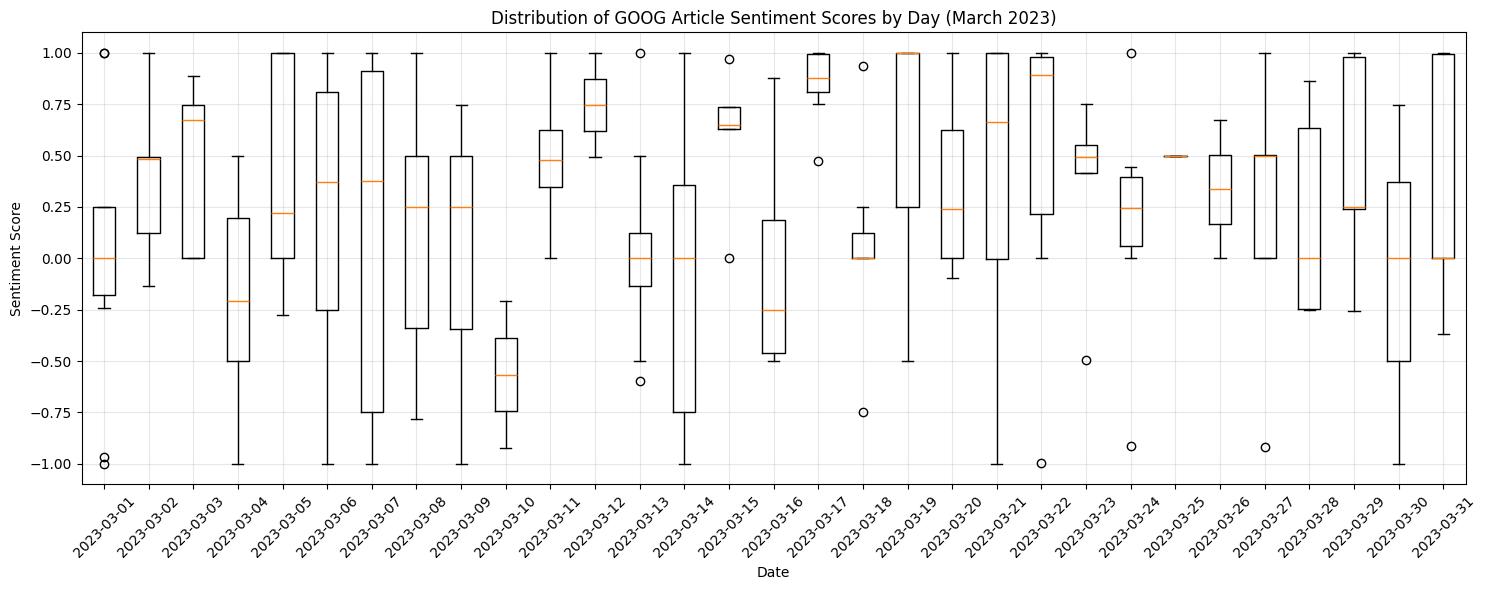


Daily Sentiment Statistics:
           avg_sentiment             
                    mean    std count
Date                                 
2023-03-01         0.029  0.675    10
2023-03-02         0.369  0.376     7
2023-03-03         0.461  0.428     5
2023-03-04        -0.202  0.587     5
2023-03-05         0.388  0.585     5
2023-03-06         0.186  0.897     4
2023-03-07         0.120  0.939     6
2023-03-08         0.127  0.666     6
2023-03-09         0.043  0.633     7
2023-03-10        -0.566  0.508     2
2023-03-11         0.490  0.409     4
2023-03-12         0.746  0.359     2
2023-03-13         0.048  0.512     8
2023-03-14        -0.088  0.797     6
2023-03-15         0.596  0.360     5
2023-03-16        -0.029  0.576     5
2023-03-17         0.852  0.190     7
2023-03-18         0.062  0.495     7
2023-03-19         0.500  0.866     3
2023-03-20         0.360  0.437     8
2023-03-21         0.399  0.686    12
2023-03-22         0.465  0.812     6
2023-03-23         0.

In [109]:
# Load GOOG articles from a small date range
goog_df = load_and_filter_fnspid(
    selected_symbols=['GOOG'],
    start_date='2023-01-01',
    end_date='2023-03-31'
)

# Analyze sentiment using FinBERT
# Use a shorter date range for efficiency
goog_df = goog_df[goog_df['Date'] >= '2023-03-01']  # Just March 2023

# Get sentiment scores
sentiment_df = analyze_finbert_sentiment(goog_df)

# Plot daily sentiment distribution
plt.figure(figsize=(15, 6))
plt.boxplot([
    sentiment_df[sentiment_df['Date'].dt.date == date]['avg_sentiment'].values 
    for date in sorted(sentiment_df['Date'].dt.date.unique())
], labels=sorted(sentiment_df['Date'].dt.date.unique()))

plt.title('Distribution of GOOG Article Sentiment Scores by Day (March 2023)')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics by day
daily_stats = sentiment_df.groupby(sentiment_df['Date'].dt.date).agg({
    'avg_sentiment': ['mean', 'std', 'count']
}).round(3)
print("\nDaily Sentiment Statistics:")
print(daily_stats)



In [122]:
# Show all columns
pd.set_option('display.max_columns', None)
# Show all rows (be careful if you have many)
pd.set_option('display.max_rows', None)

sentiment_df.drop('Article', axis=1).head(10).iloc[0].to_dict()



{'Date': Timestamp('2023-03-31 00:00:00'),
 'Stock_symbol': 'GOOG',
 'Article_title': "Don't Wait Until the Dip Is Over to Buy These 2 Magnificent Growth Stocks",
 'Lsa_summary': "That cash can be put to good use in the form of growth-enhancing investment and supporting Google Cloud's march to profitability, so there's considerable upside for the stock. Data center equipment company Vertiv (NYSE: VRT) and Google owner Alphabet (NASDAQ: GOOG) (NASDAQ: GOOGL) are two great stocks to consider. It also sells into growth markets like the cloud/hyper-scale market, which includes companies like Microsoft's Azure, Amazon Web Services, and Google Cloud.",
 'Luhn_summary': "Data center equipment company Vertiv (NYSE: VRT) and Google owner Alphabet (NASDAQ: GOOG) (NASDAQ: GOOGL) are two great stocks to consider. It also sells into growth markets like the cloud/hyper-scale market, which includes companies like Microsoft's Azure, Amazon Web Services, and Google Cloud. Indeed, Google Cloud's growth 

In [123]:
aggregate_daily_sentiment(sentiment_df).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Stock_symbol      31 non-null     object 
 1   Date              31 non-null     object 
 2   daily_sentiment   31 non-null     float64
 3   sentiment_std     30 non-null     float64
 4   article_count     31 non-null     int64  
 5   sentiment_median  31 non-null     float64
 6   sentiment_min     31 non-null     float64
 7   sentiment_max     31 non-null     float64
 8   positive_ratio    31 non-null     float64
 9   negative_ratio    31 non-null     float64
 10  neutral_ratio     31 non-null     float64
 11  sentiment_range   31 non-null     float64
dtypes: float64(9), int64(1), object(2)
memory usage: 3.0+ KB


/var/folders/w4/5fjrknc54qjdkx2hts27gd6m0000gn/T/ipykernel_20047/2569914408.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_ratios)


,Unnamed: 0,Date,Article_title,Stock_symbol,Url,Publisher,Author,Article,Lsa_summary,Luhn_summary,Textrank_summary,Lexrank_summary
109244,1161179.0,2023-03-31,Don't Wait Until the Dip Is Over to Buy These ...,GOOG,https://www.nasdaq.com/articles/dont-wait-unti...,,,"After a positive start in January, the S&P 500...",That cash can be put to good use in the form o...,Data center equipment company Vertiv (NYSE: VR...,Data center equipment company Vertiv (NYSE: VR...,"Indeed, Google Cloud's growth (revenue up 32% ..."
109245,1161180.0,2023-03-31,Why Alphabet Was Rising Today,GOOG,https://www.nasdaq.com/articles/why-alphabet-w...,,,What happened\nShares of tech giant Alphabet (...,What happened Shares of tech giant Alphabet (N...,What happened Shares of tech giant Alphabet (N...,What happened Shares of tech giant Alphabet (N...,What happened Shares of tech giant Alphabet (N...
109246,1161181.0,2023-03-31,"The Future of Data Center CPUs: AMD, Intel, Nv...",GOOG,https://www.nasdaq.com/articles/the-future-of-...,,,"Advanced Micro Devices (NASDAQ: AMD), Intel (N...",* They just revealed what they believe are the...,"Advanced Micro Devices (NASDAQ: AMD), Intel (N...","Advanced Micro Devices (NASDAQ: AMD), Intel (N...",See the 10 stocks *Stock Advisor returns as of...
109247,1161182.0,2023-03-31,The 3 Best Tech Stocks to Buy for Exposure to ...,GOOG,https://www.nasdaq.com/articles/the-3-best-tec...,,,"InvestorPlace - Stock Market News, Stock Advic...","Alphabet (GOOG, GOOGL) Source: turbaliska / Sh...",Many of the world’s leading AI researchers and...,"The company’s cloud computing platform, Google...","Alphabet (GOOG, GOOGL) Source: turbaliska / Sh..."
109248,1161183.0,2023-03-31,Google's Owner Has More Money Than It Knows Wh...,GOOG,https://www.nasdaq.com/articles/googles-owner-...,,,Few companies have enough money that they coul...,That's the case for Alphabet (NASDAQ: GOOG)(NA...,That's the case for Alphabet (NASDAQ: GOOG)(NA...,That's the case for Alphabet (NASDAQ: GOOG)(NA...,That's the case for Alphabet (NASDAQ: GOOG)(NA...


In [129]:
# Load GOOG articles from a small date range
goog_df = load_and_filter_fnspid(
    selected_symbols=['GOOG'],
    start_date='2023-01-01',
    end_date='2024-12-31'
)

Using custom data configuration benstaf--FNSPID-filtered-nasdaq-100-cb77f2f406eb844d
Reusing dataset parquet (/Users/wins/.cache/huggingface/datasets/benstaf___parquet/benstaf--FNSPID-filtered-nasdaq-100-cb77f2f406eb844d/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)
100%|██████████| 1/1 [00:00<00:00, 31.64it/s]


In [133]:
goog_df.head()

,Unnamed: 0,Date,Article_title,Stock_symbol,Url,Publisher,Author,Article,Lsa_summary,Luhn_summary,Textrank_summary,Lexrank_summary
107508,1159443.0,2023-12-16 23:00:00,Alphabet Inc. (GOOG) Rises As Market Takes a D...,GOOG,https://www.nasdaq.com/articles/alphabet-inc.-...,,,"In the latest trading session, Alphabet Inc. (...","In the latest trading session, Alphabet Inc. (...","In the latest trading session, Alphabet Inc. (...","In the latest trading session, Alphabet Inc. (...","In the latest trading session, Alphabet Inc. (..."
107509,1159444.0,2023-12-16 21:00:00,"Technology Sector Update for 12/20/2023: PL, G...",GOOG,https://www.nasdaq.com/articles/technology-sec...,,,Tech stocks were lower late Wednesday afternoo...,Alphabet's (GOOG) Google was fined 4.6 billion...,Alphabet's (GOOG) Google was fined 4.6 billion...,Alphabet's (GOOG) Google was fined 4.6 billion...,Alphabet's (GOOG) Google was fined 4.6 billion...
107510,1159445.0,2023-12-16 19:00:00,"Technology Sector Update for 12/20/2023: GOOG,...",GOOG,https://www.nasdaq.com/articles/technology-sec...,,,Tech stocks were mixed Wednesday afternoon wit...,"In corporate news, Alphabet's (GOOG) Google wa...","In corporate news, Alphabet's (GOOG) Google wa...","In corporate news, Alphabet's (GOOG) Google wa...","In corporate news, Alphabet's (GOOG) Google wa..."
107511,1159446.0,2023-12-16 19:00:00,"Notable Wednesday Option Activity: STX, GOOG, CVS",GOOG,https://www.nasdaq.com/articles/notable-wednes...,,,Looking at options trading activity among comp...,Especially high volume was seen for the $141 s...,Below is a chart showing STX's trailing twelve...,Below is a chart showing STX's trailing twelve...,Below is a chart showing STX's trailing twelve...
107512,1159447.0,2023-12-16 19:00:00,Why Alphabet Stock Was Climbing Today,GOOG,https://www.nasdaq.com/articles/why-alphabet-s...,,,Shares of Alphabet (NASDAQ: GOOG) (NASDAQ: GOO...,The move comes as Google plans to step up its ...,Shares of Alphabet (NASDAQ: GOOG) (NASDAQ: GOO...,Shares of Alphabet (NASDAQ: GOOG) (NASDAQ: GOO...,Shares of Alphabet (NASDAQ: GOOG) (NASDAQ: GOO...
